# Importing all libraries and source files

In [3]:
import cv2
import time
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image
transform = T.ToPILImage()


To keep the backend simple we are sticking to a PyTorch Backend for both our upscaling model and detection model

In [ ]:
!pip install pyyaml==5.1
!git clone --branch v0.6 https://github.com/facebookresearch/detectron2.git detectron2_repo
!pip install -e detectron2_repo

In [ ]:
!git clone https://github.com/Nhat-Thanh/ESPCN-Pytorch.git

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Setting up video capture and detector

# Functions

Detect(img) : Takes image as input and carries out Object detection using detector()


In [23]:
from detectron2.utils.visualizer import Visualizer
def Detect(img):
  results = detector(img)
  v = Visualizer(img[:, :, ::-1], Drones_metadata, scale=1.2)
  detections = v.draw_instance_predictions(results["instances"].to("cpu")).get_image()
  return detections


getDetector(): function returns our custom trained object detection models predictor. It does so by loading trained weights on to the network.

In [14]:
def getDetector():
  import detectron2
  from detectron2 import model_zoo
  from detectron2.engine import DefaultPredictor
  from detectron2.config import get_cfg
  from detectron2.utils.visualizer import Visualizer, ColorMode
  from detectron2.projects import point_rend
  cfg = get_cfg()
  point_rend.add_pointrend_config(cfg)
  cfg.merge_from_file("/content/detectron2_repo/projects/PointRend/configs/InstanceSegmentation/pointrend_rcnn_R_101_FPN_3x_coco.yaml") 
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8 # Set threshold for this model
  cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/Point_rend Final/model_final.pth' # Set path model .pth
  cfg.MODEL.POINT_HEAD.NUM_CLASSES = 2 
  cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 
  predictor = DefaultPredictor(cfg)
  return predictor

Upscale_img(img) : Takes in input (img) and upscales it using an ESPCN model 
                   Does 2x upscaling of image.

In [10]:
from utils.common import *
from model import ESPCN 
def Upscale_img(lr_image):
    
    lr_image = gaussian_blur(lr_image, sigma=0.3)
    lr_image = rgb2ycbcr(lr_image)
    lr_image = norm01(lr_image)
    lr_image = torch.unsqueeze(lr_image, dim=0)
    model = ESPCN(scale, device)
    model.load_weights(ckpt_path)
    with torch.no_grad():
        lr_image = lr_image.to(device)
        sr_image = model.predict(lr_image)[0]

    sr_image = denorm01(sr_image)
    sr_image = sr_image.type(torch.uint8)
    sr_image = ycbcr2rgb(sr_image)
    img = transform(sr_image)
    img = cv2.cvtColor(numpy.array(img), cv2.COLOR_RGB2BGR)
    # write_image("/content/Upscaled/sr.png", sr_image)
    # img = cv2.imread('/content/Upscaled/sr.png')
    return img

# Uploading Drone Metadata for detection

In [25]:
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
register_coco_instances("Drones_train", {}, "/content/drive/MyDrive/DATA_AUG_DRONE/train/_annotations.coco.json", "/content/drive/MyDrive/DATA_AUG_DRONE/train")
Drones_metadata = MetadataCatalog.get("Drones_train")


In [31]:
cap = cv2.VideoCapture('/content/V_DRONE_006.mp4')
detector = getDetector()
pTime = 0

In [27]:
from google.colab.patches import cv2_imshow


/content/detectron2_repo/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/content/detectron2_repo/projects/PointRend/point_rend/point_features.py:142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  point_coords[:, :, 1] = h_step / 2.0 + (point

0.018044410649645015


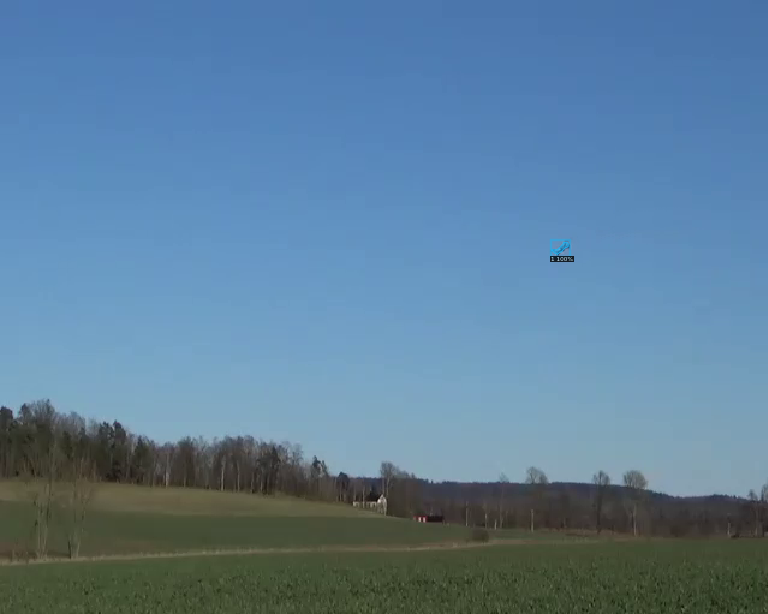

3.4652500433744495


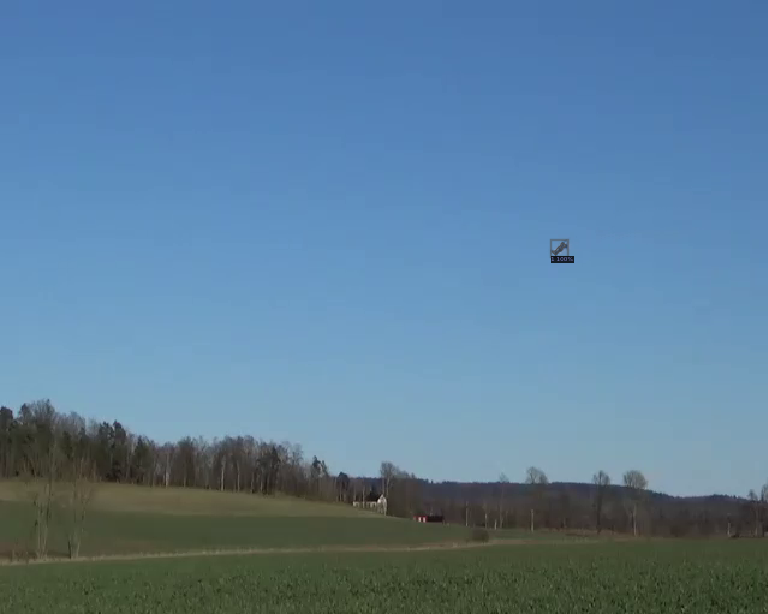

3.523020607420822


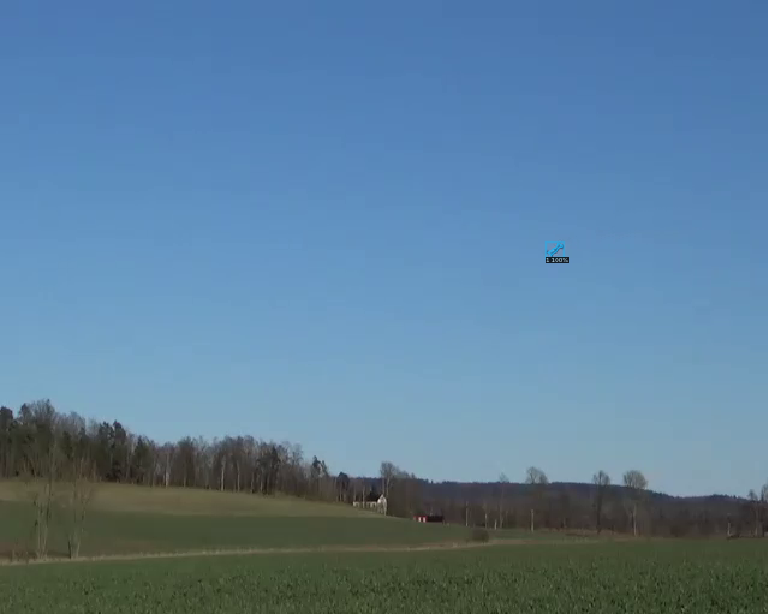

3.7311290962497488


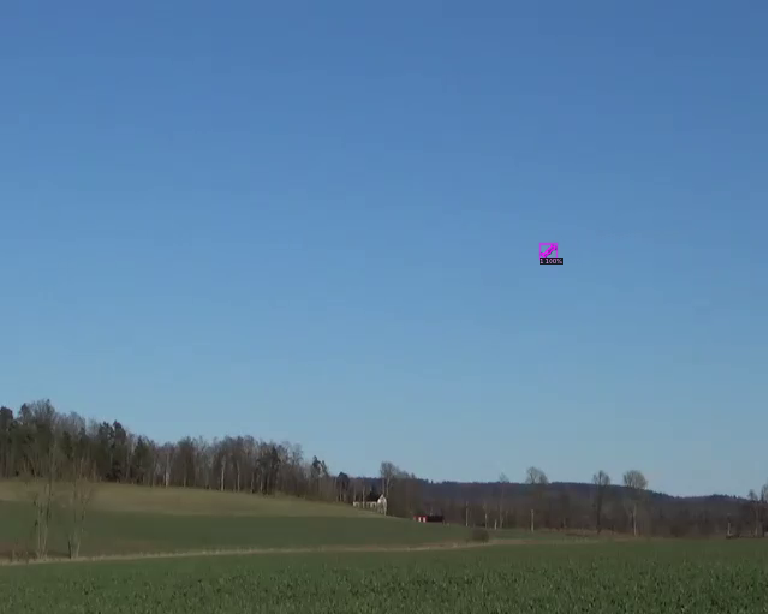

3.7093016777315646


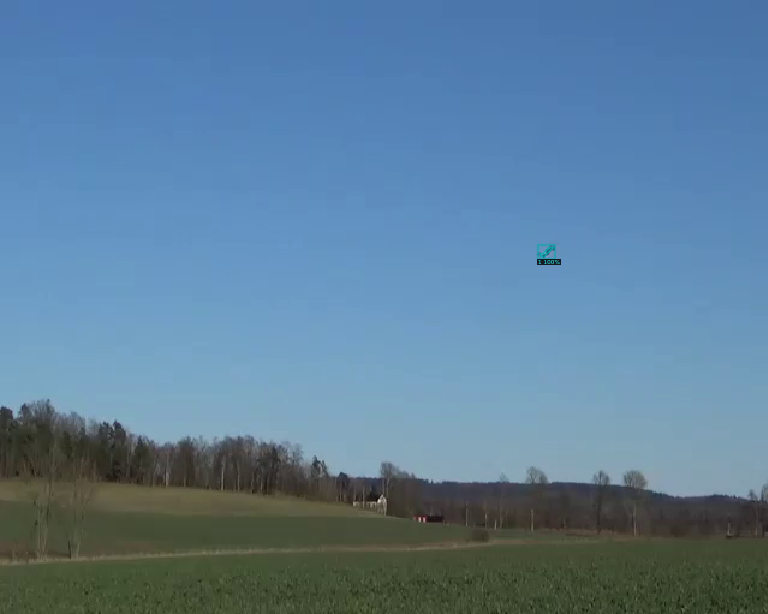

3.83053355081345


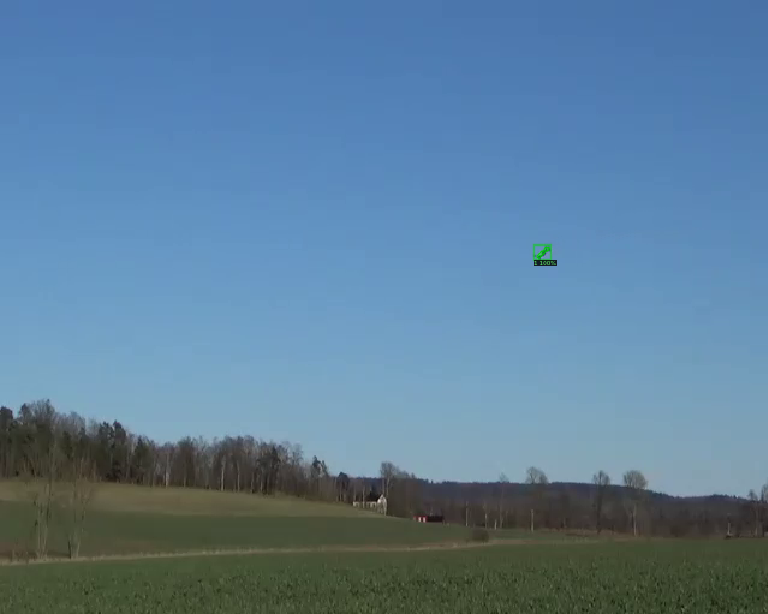

3.5786202748187996


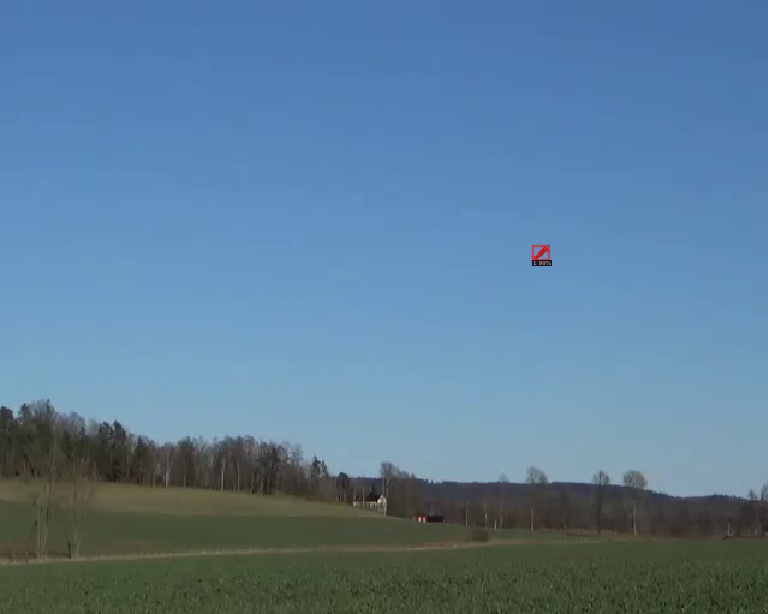

3.806086938372902


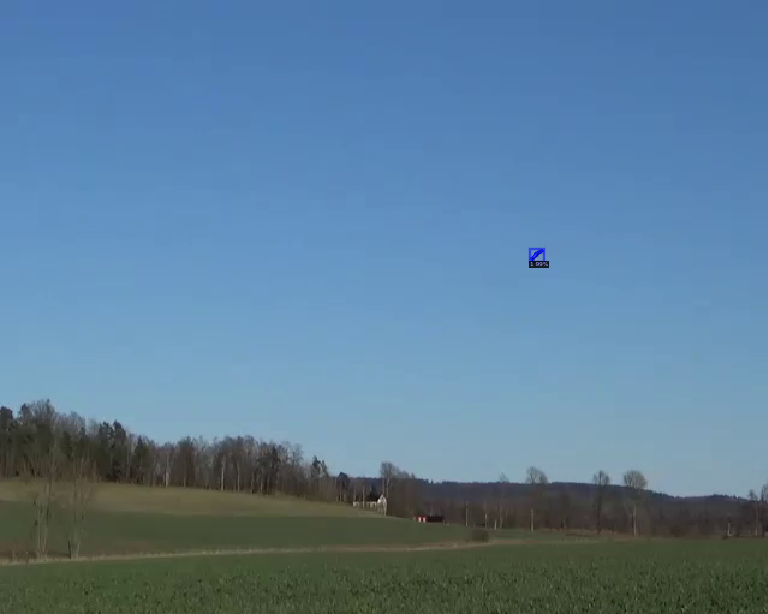

3.761336549757423


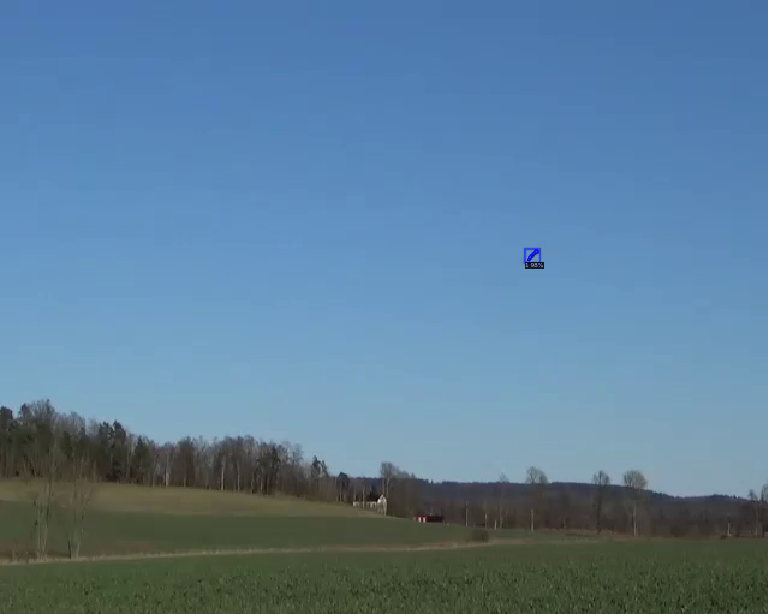

3.4237539385826


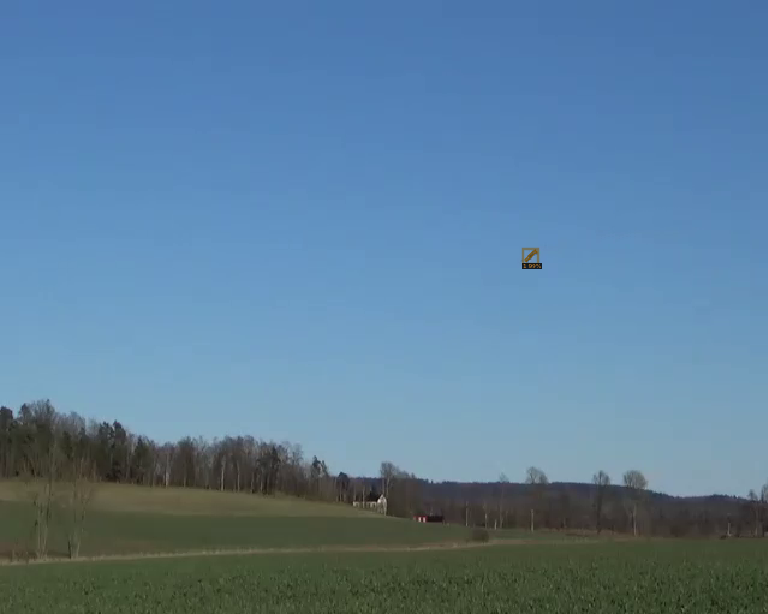

3.671307841446709


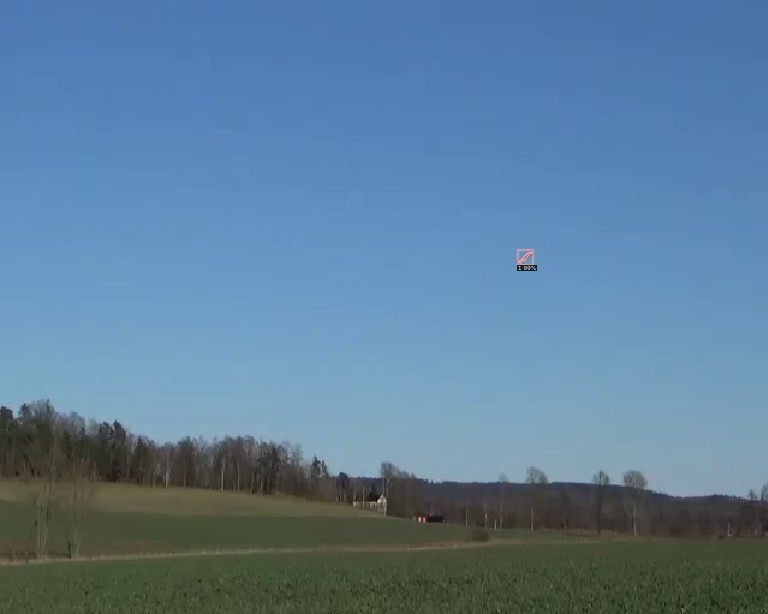

3.617095184627511


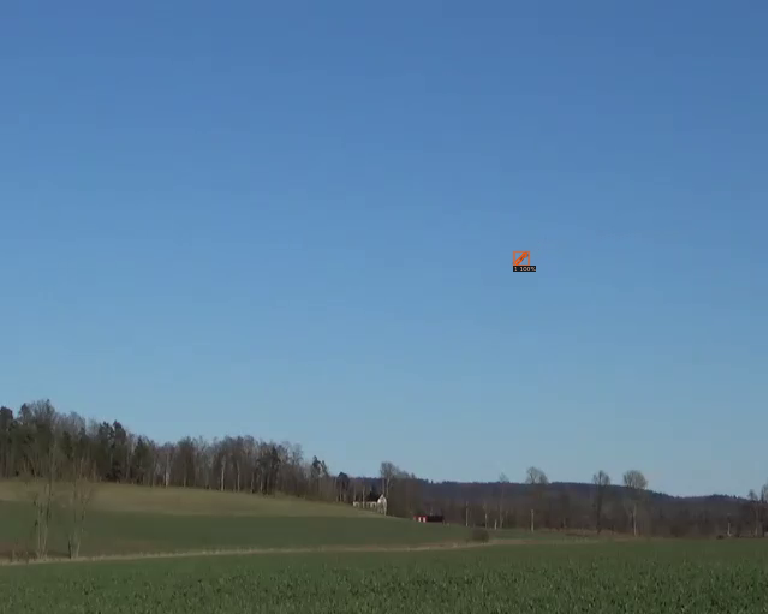

3.781946975428143


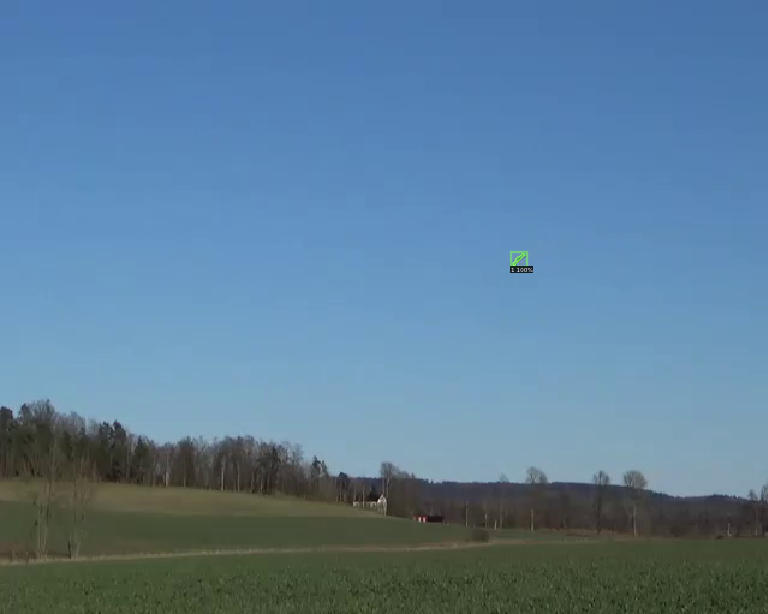

3.5708177891139665


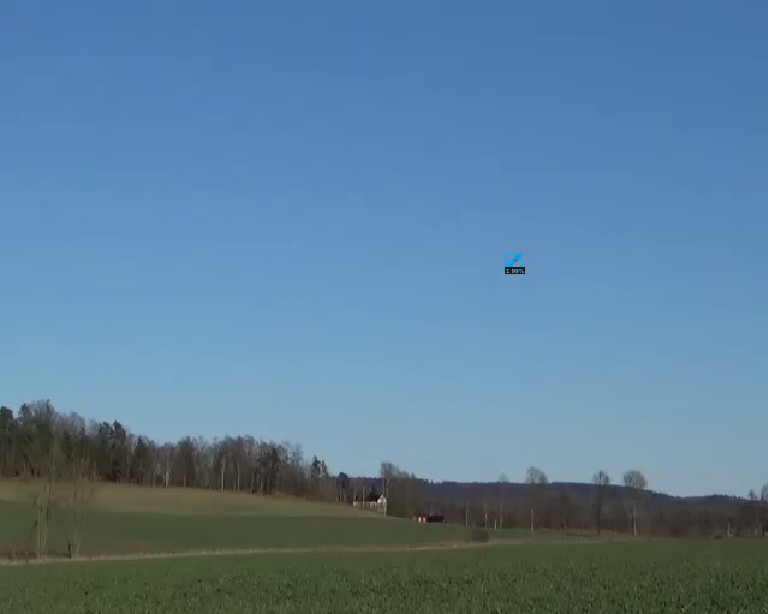

3.8276181784997263


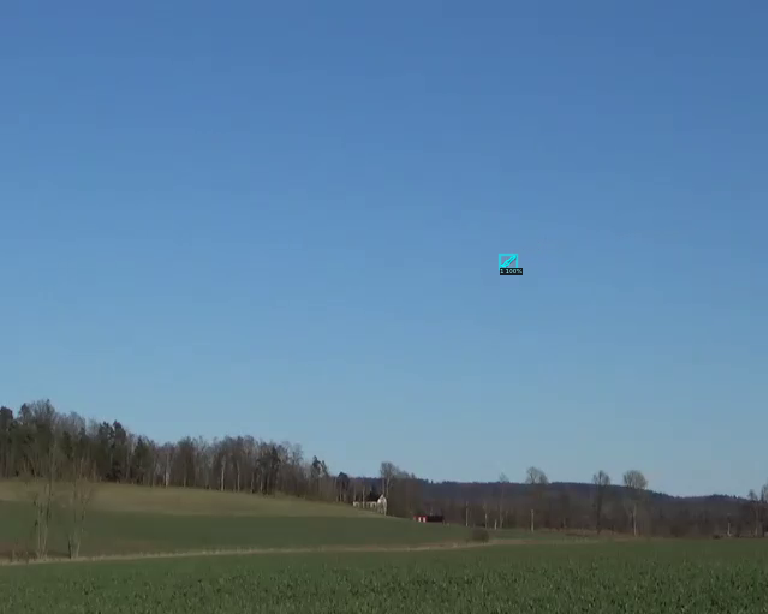

3.764344352411869


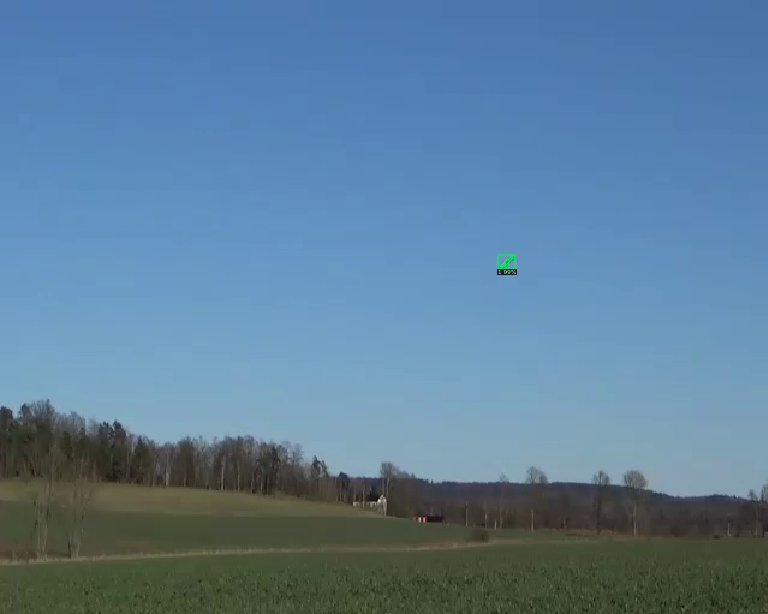

3.65663910001238


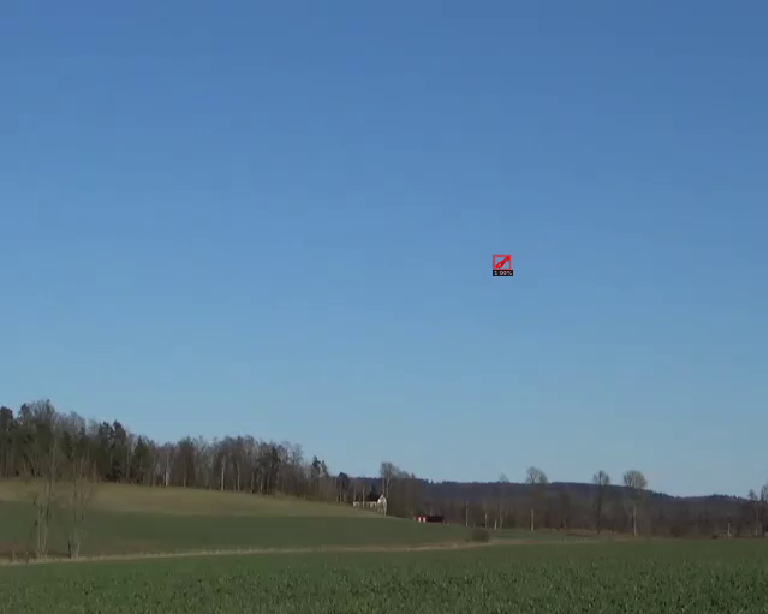

3.5044349529099574


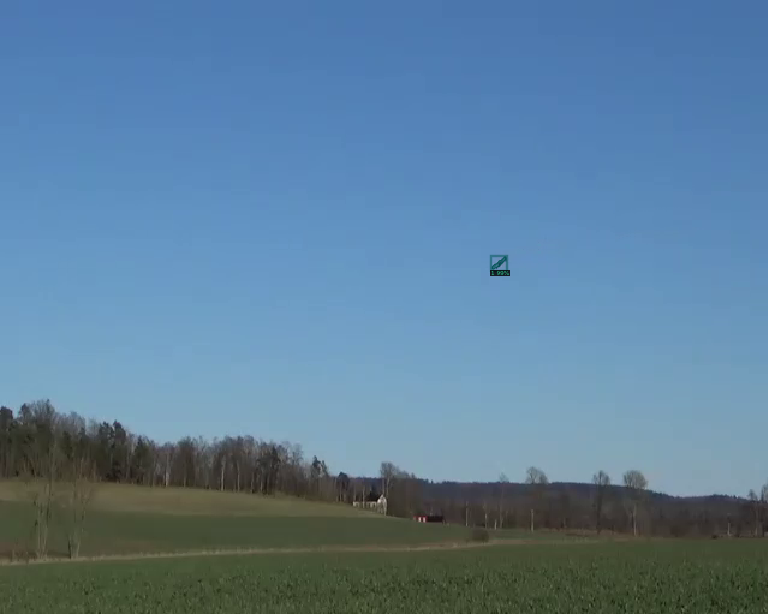

3.661034110439301


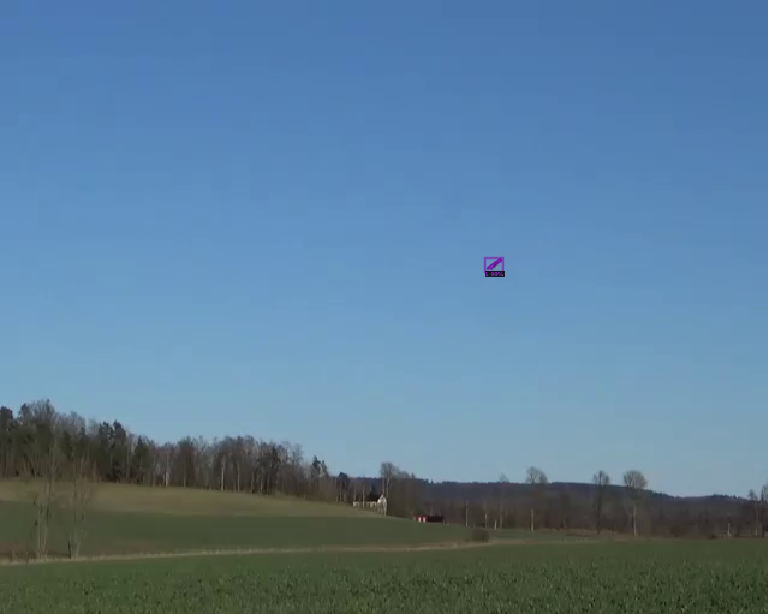

3.633807380582112


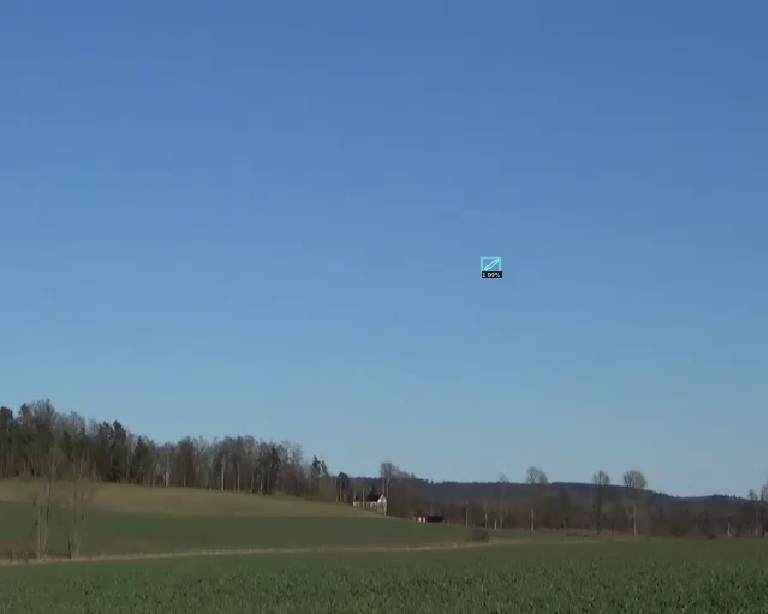

3.4635674636533444


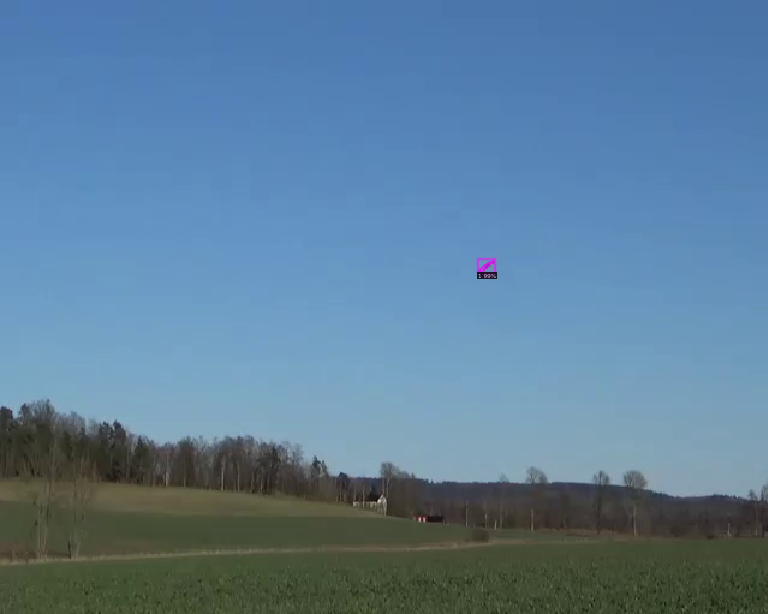

3.7265079979956144


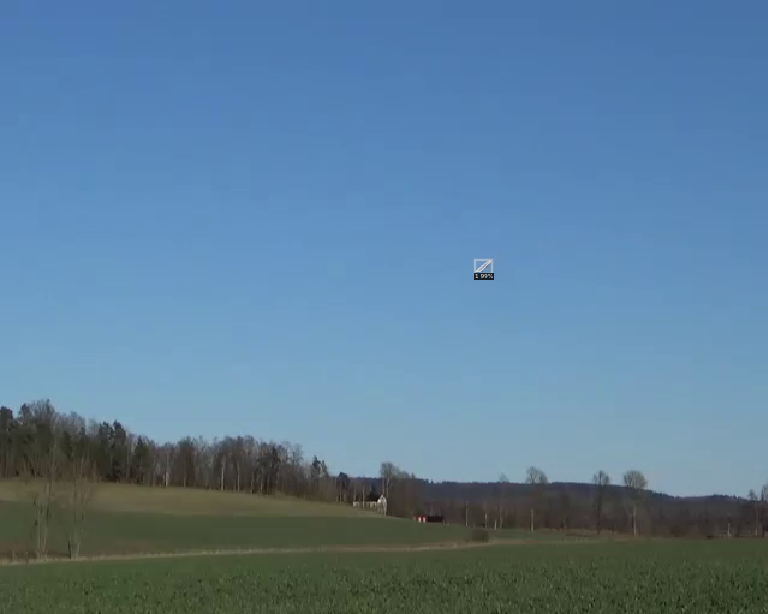

3.5109443286956625


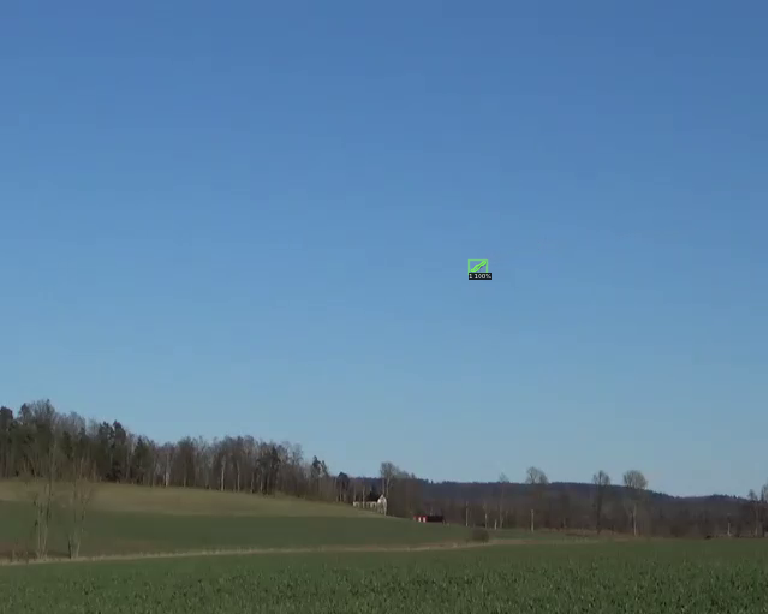

4.105160441023181


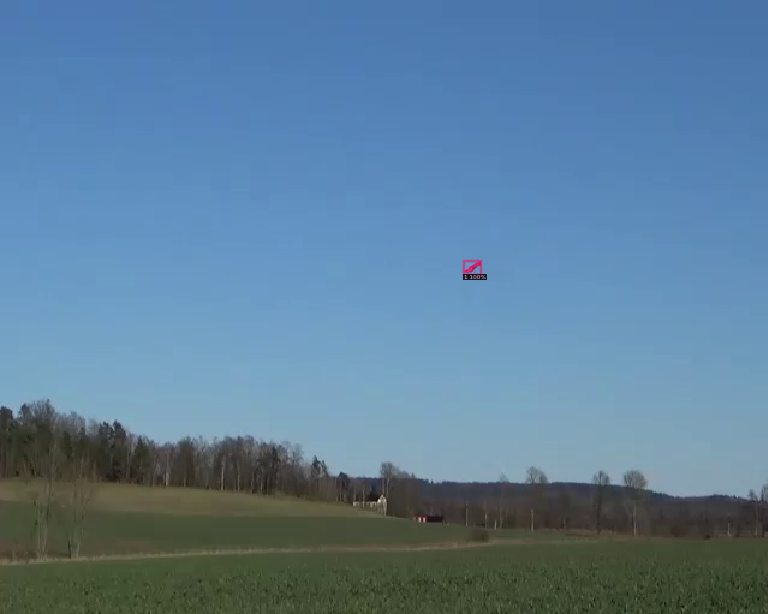

3.670164182878884


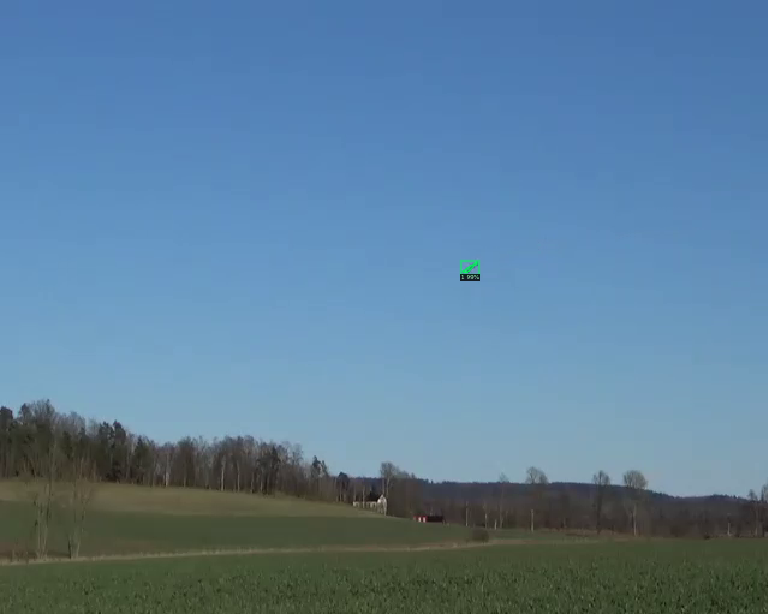

3.6182777935453707


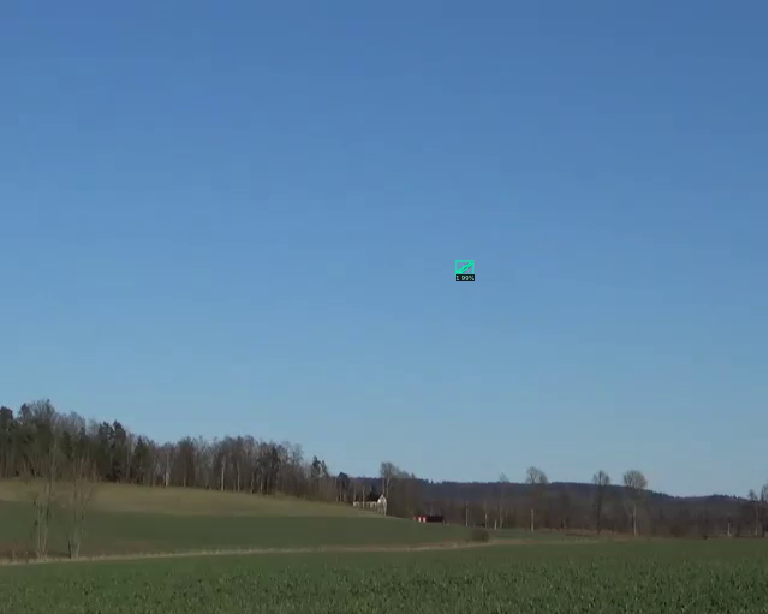

3.862236619894694


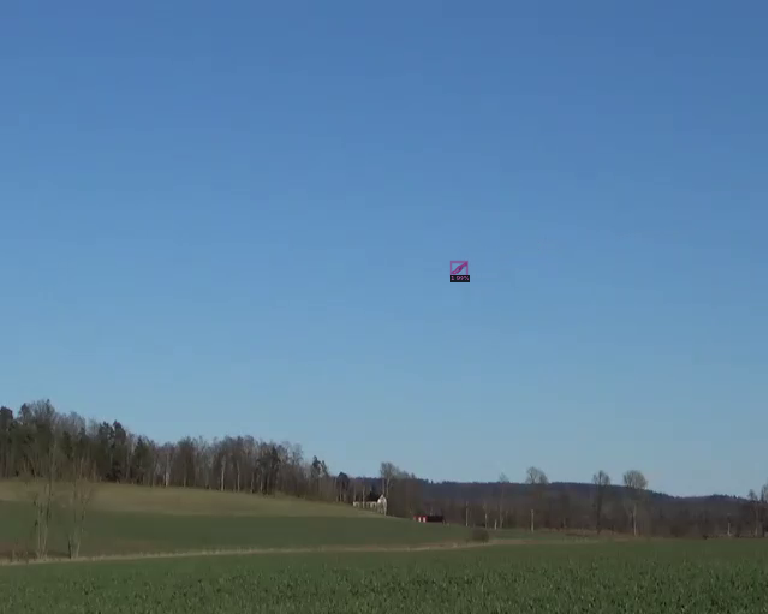

3.7501041620099245


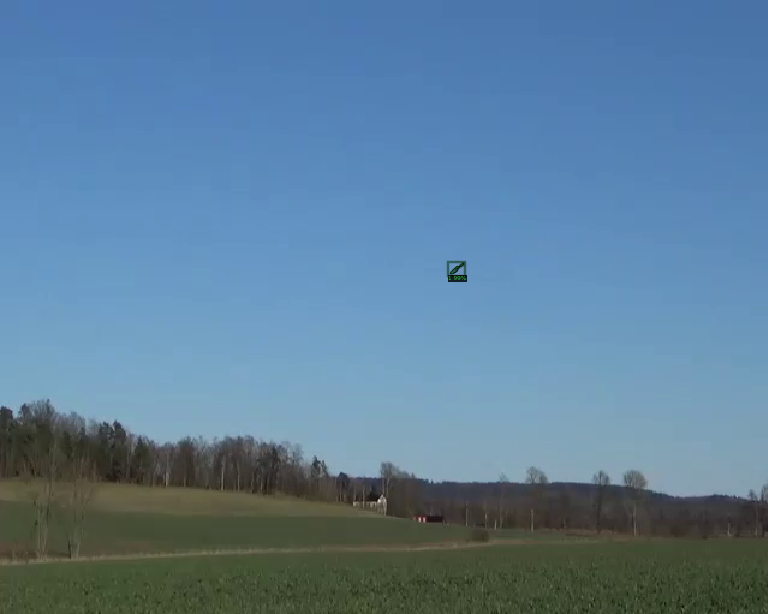

3.715311216698378


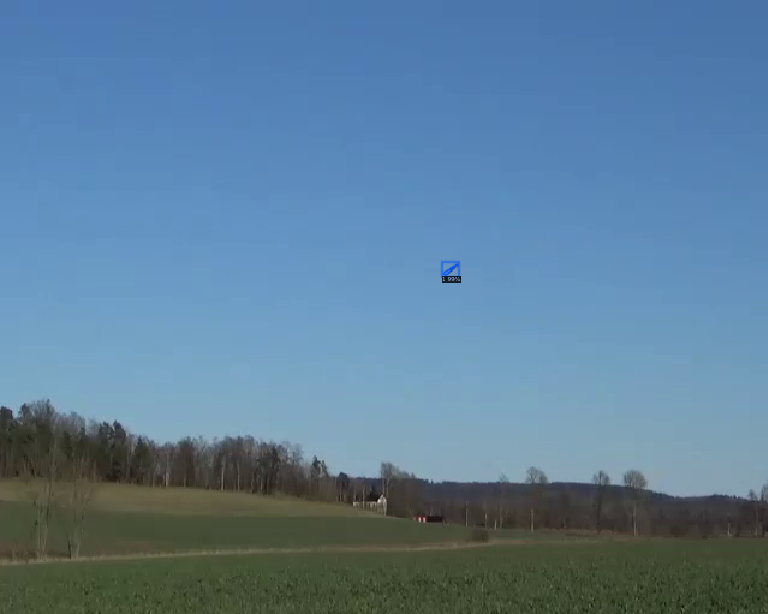

3.6535048979897597


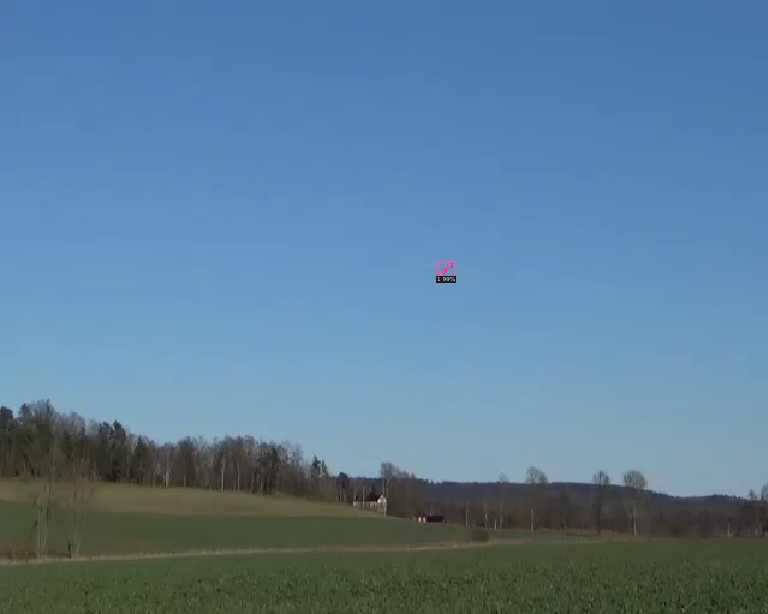

3.674772073756459


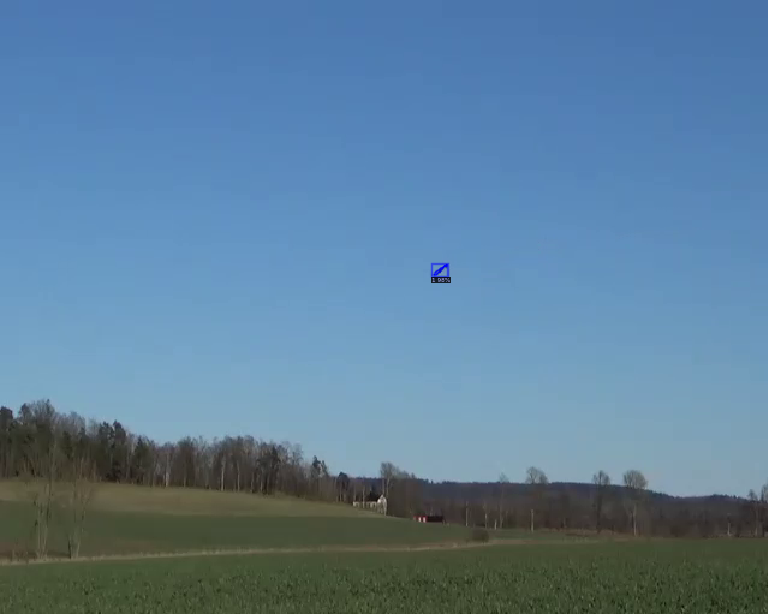

3.7031938394056954


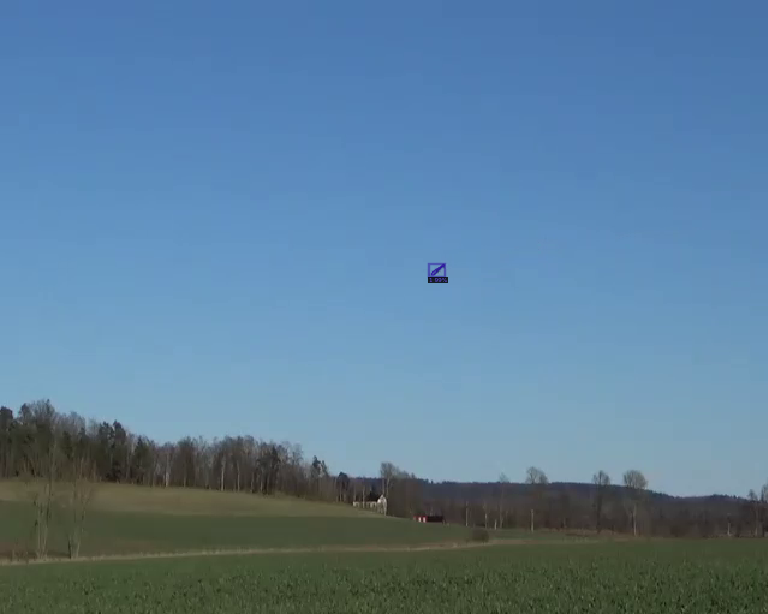

3.722251754718371


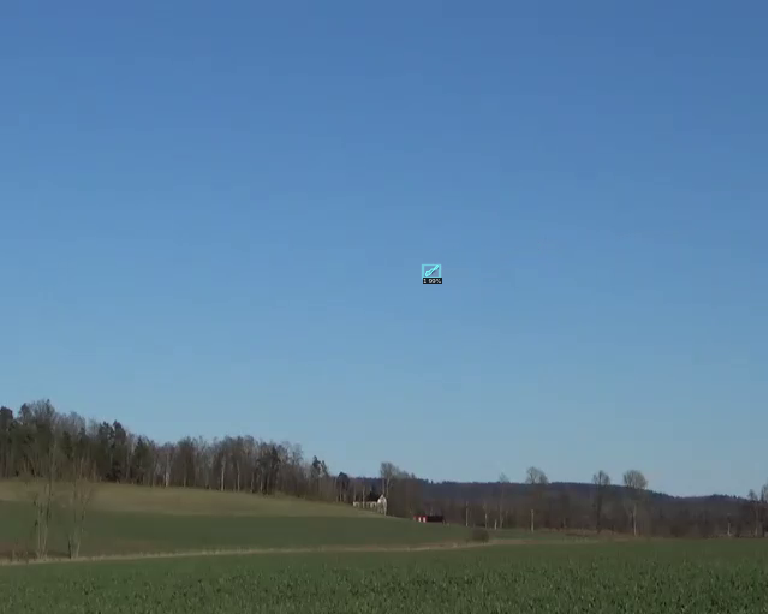

3.731185521843289


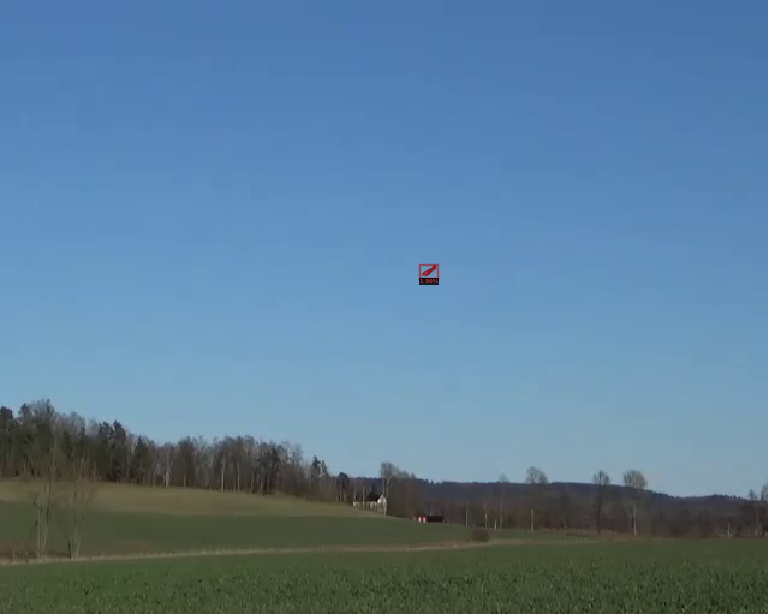

3.687553080562887


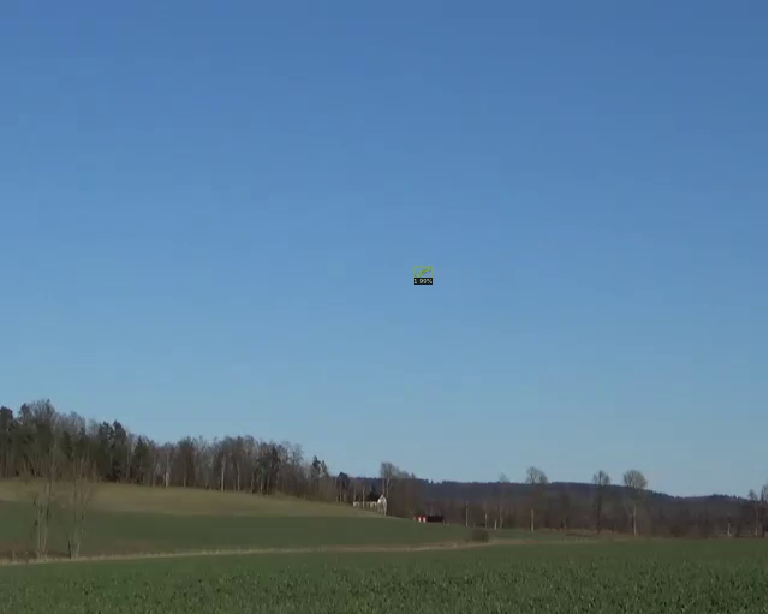

3.650948011274118


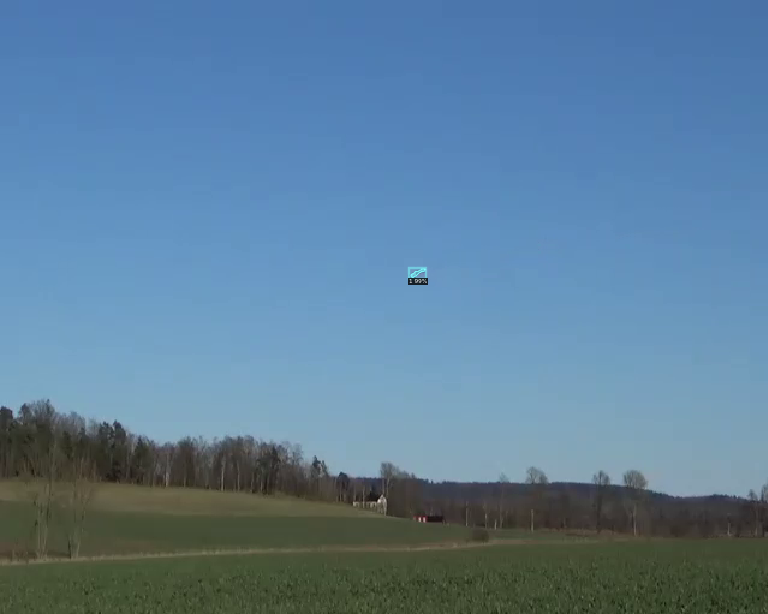

3.6942177439953494


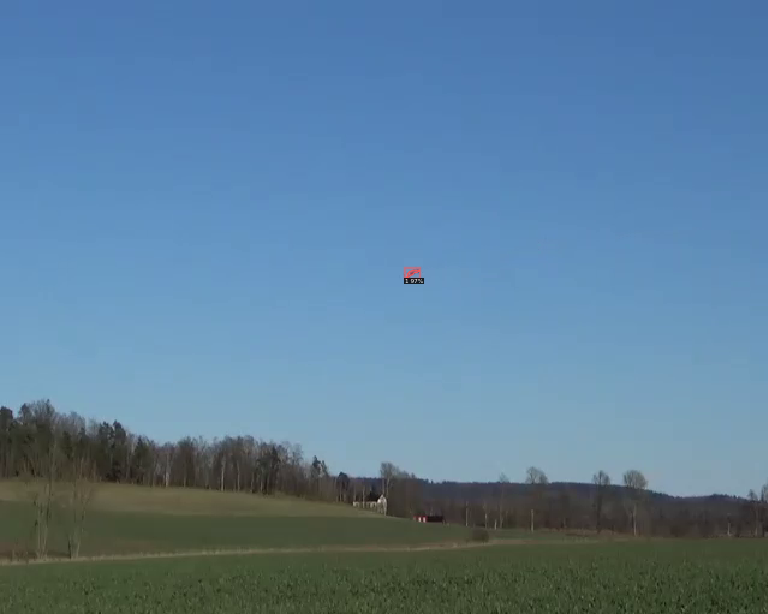

3.818634386340586


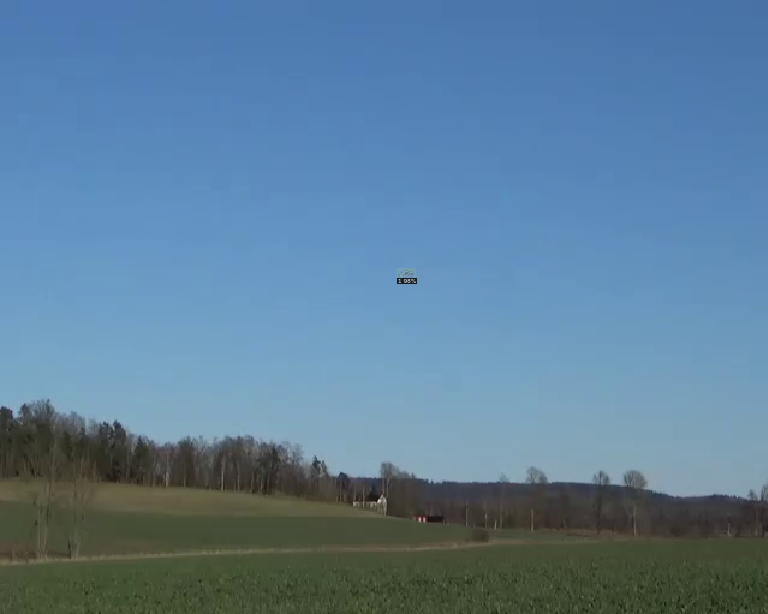

3.758805084145785


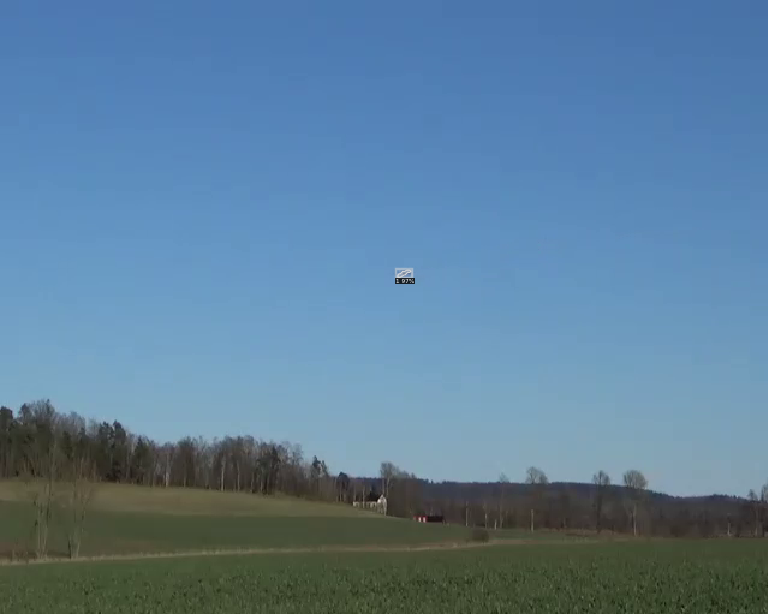

3.6775849294829923


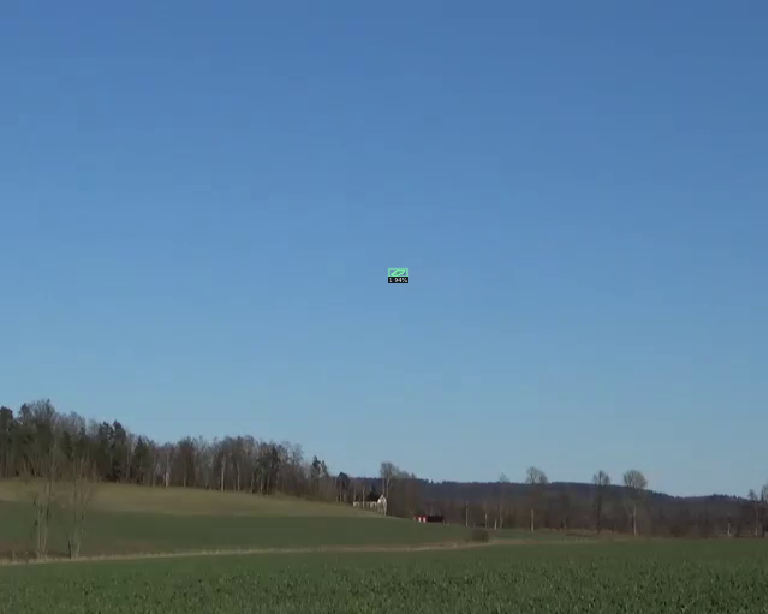

3.7084620900452605


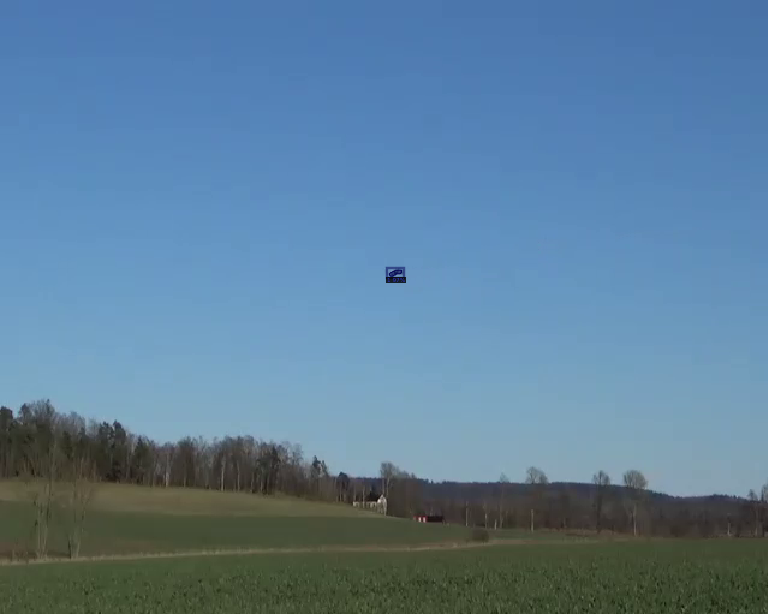

3.639713564716949


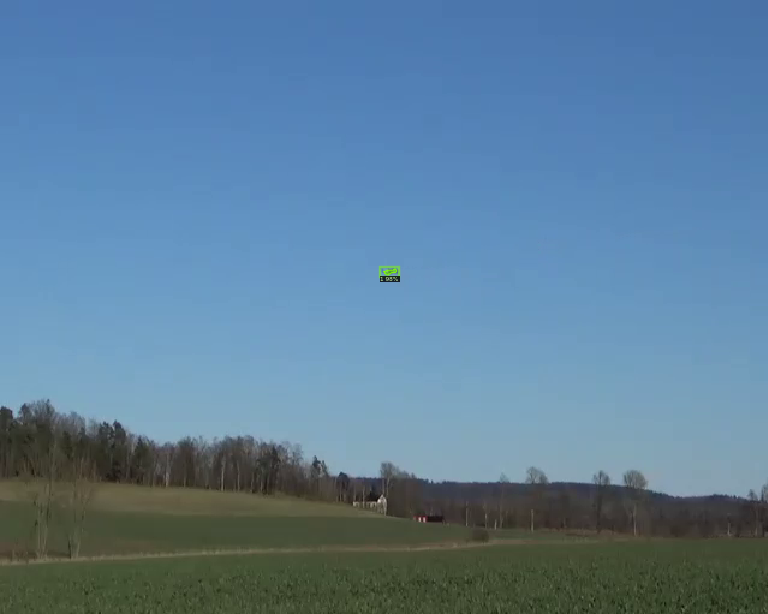

3.5563243125913075


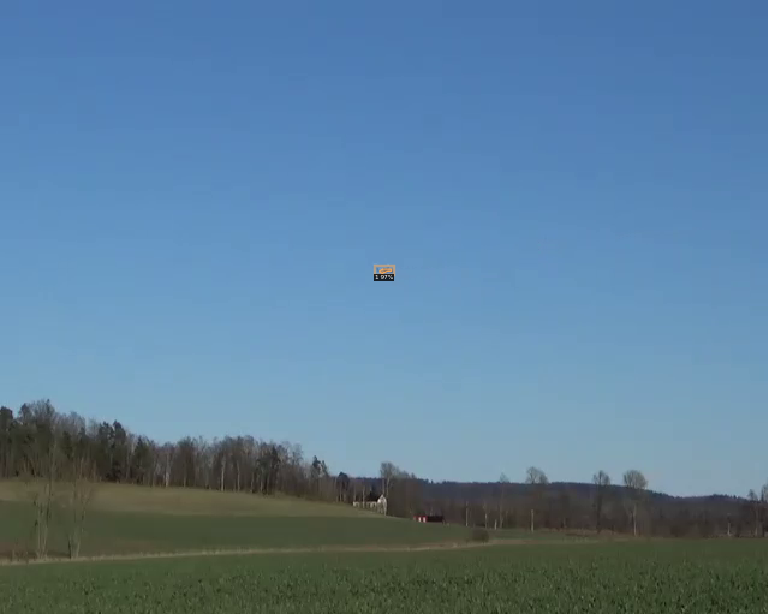

3.6429475337191417


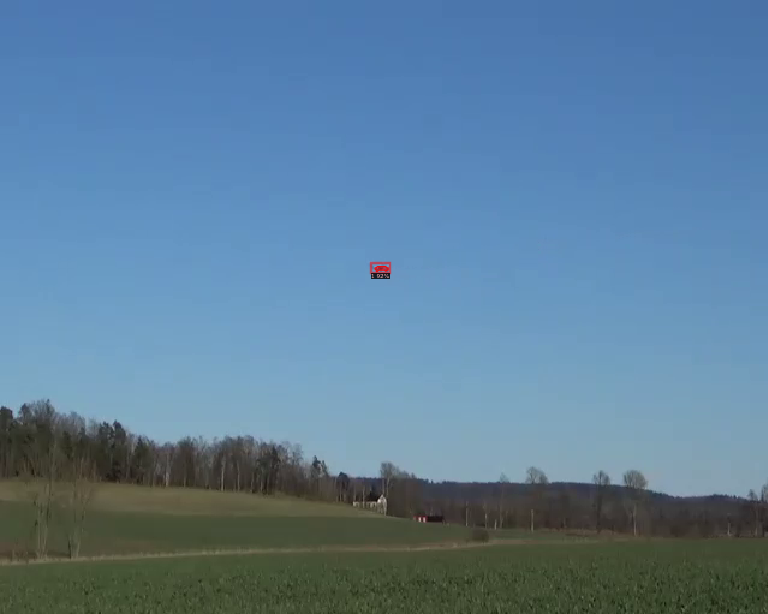

3.53141799646547


KeyboardInterrupt: ignored

In [35]:
while True:
  # read video input
  success, img = cap.read()

  # Getting size of image
  height = img.shape[0]
  width = img.shape[1]
  A = (height * width)/10000
  A_min = 250000
  # Chech whether the image needs enhancement : if the size of the image < 600*600
  if A < A_min:
    img = Upscale_img(img)
   
  # convert frames to RGB colorspace for Detection
  imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Detecting for drones in captured frame
  instances = Detect(imgRGB)

  # Calculating fps 
  cTime = time.time()
  fps = 1/(cTime-pTime)
  pTime = cTime
  print(fps)

  # displaying results
  cv2.putText(img, str(int (fps)), (70, 50), cv2.FONT_HERSHEY_PLAIN, 3,(255, 0, 0) ,3)
  cv2_imshow(instances)
  cv2.waitKey(1) & 0xff
cv2.destroyAllWindows()
cap.release()


In [36]:
!nvidia-smi 


Sun Aug  7 20:04:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |   2134MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------